In [1]:
cd ..

m:\OneDrive\Projects\federated_imputation_pc1


## Loading

In [1]:
%load_ext autoreload
%autoreload
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from src.modules.data_spliting import split_train_test
from src.modules.data_preprocessing import load_data
import random
from src.modules.data_partition import data_partition
from src.fed_imp.sub_modules.missing_simulate.missing_adder_new import add_missing
from src.fed_imp.sub_modules.client.client_factory import ClientsFactory
from src.fed_imp.sub_modules.strategy.strategy_imp import StrategyImputation
from src.fed_imp.sub_modules.server.load_server import load_server
from src.fed_imp.sub_modules.client.simple_client import SimpleClient
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from dython.nominal import correlation_ratio
import missingno as msno


ModuleNotFoundError: No module named 'src.modules'

In [3]:
def visualize_ms(clients_ms_datas:list, sort_patterns: bool = False):
    n_cols = 5
    n_clients = len(clients_ms_datas)
    n_rows = (n_clients + 4)//n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3), squeeze=False)
    for i in range(n_clients):
        ax = axes[i//n_cols, i%n_cols]
        d = pd.DataFrame(clients_ms_datas[i])
        d = d.sort_values(by=d.columns[-1])
        if sort_patterns:
            msno.matrix(d, ax=ax, sparkline=False, sort='ascending')
        else:
            msno.matrix(d, ax=ax, sparkline=False)
        ax.set_title('Client {}'.format(i))
    plt.tight_layout()

def correlation(original_data, centralized_data):
    original_df = pd.DataFrame(original_data)
    target_col = original_df.columns[-1]
    correlation_ret = original_df.corrwith(original_df[target_col], method=correlation_ratio).sort_values(ascending=False)
    print(correlation_ret)

    centralized_df = pd.DataFrame(centralized_data)
    target_col = centralized_df.columns[-1]
    correlation_ret = centralized_df.corrwith(original_df[target_col], method=correlation_ratio).sort_values(ascending=False)
    print(correlation_ret)

def run_pred(clf_name, X_train, y_train, X_test, y_test):
    accus = []
    for i in range(5):
        seed = 21 + i*93940
        if clf_name == 'LR':
            clf = LogisticRegression(random_state=seed, max_iter=1000)
        elif clf_name == 'MLP':
            clf = MLPClassifier(
                [32, 32], batch_size = 128, random_state=seed, alpha = 0.001, max_iter = 1000)
        else:
            raise ValueError('clf_name should be LR or MLP')
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accus.append(metrics.accuracy_score(y_test, y_pred))
    return np.mean(accus), np.std(accus)

def sklearn_evaluation(rets):

    original_data = rets['data']['origin_data'].reshape(-1, rets['data']['origin_data'].shape[-1])
    centralized_data = rets['data']['imputed_data'].reshape(-1, rets['data']['origin_data'].shape[-1])
    test_data = rets['data']['test_data']

    X_train = centralized_data[:, :-1]
    y_train = centralized_data[:, -1]
    X_test = test_data[:, :-1]
    y_test = test_data[:, -1]
    accu, std = run_pred('MLP', X_train, y_train, X_test, y_test)
    print("Accuracy imputed centralized MLP:{:.4f} ({:.3f})".format(accu, std))

    accu, std = run_pred('LR', X_train, y_train, X_test, y_test)
    print("Accuracy imputed centralized LR:{:.4f} ({:.3f})".format(accu, std))

    X_train = original_data[:, :-1]
    y_train = original_data[:, -1]
    X_test = test_data[:, :-1]
    y_test = test_data[:, -1]
    accu, std = run_pred('MLP', X_train, y_train, X_test, y_test)
    print("Accuracy orignal centralized MLP:{:.4f} ({:.3f})".format(accu, std))

    accu, std = run_pred('LR', X_train, y_train, X_test, y_test)
    print("Accuracy orignal centralized MLP:{:.4f} ({:.3f})".format(accu, std))


In [4]:
experiment_config_template = {
  "num_clients": 20,
  "data": {
    "dataset_name": "ijcnn_balanced_pca",
    "normalize": True
  },
  "data_partition": {
    "strategy": "sample@p=0.01",
    "params": {}
  },
  "missing_simulate": {
    "mr_strategy": "fixed",
    "mf_strategy": "all",
    "mm_strategy": "mary_lr"
  },
  "imputation": {
    "initial_strategy_num": "mean",
    "initial_strategy_cat": "mode",
    "estimator_num": "ridge_cv",
    "estimator_cat": "logistic_cv",
    "imp_evaluation_model": "logistic",
    "imp_evaluation_params": {
      "tune_params": "gridsearch"
    },
    "clip": False
  },
  "agg_strategy_imp": {
    "strategy": "fedavg-s",
    "params": {
      "ms_field": "missing_cell_pct",
      "beta": 0.7
    }
  },
  "server_type": "fedavg_pytorch",
  "server": {
    "impute_mode": "instant",
    "imp_round": 20,
    "imp_local_epochs": 0,
    "pred_round": 0,
    "pred_local_epochs": 0,
    "model_fit_mode": "one_shot"
  },
  "pred_model": {
    "model_params": {
      "model": "2nn",
      "num_hiddens": 128,
      "model_init_config": None,
      "model_other_params": None
    },
    "train_params": {
      "batch_size": 128,
      "learning_rate": 0.001,
      "weight_decay": 0.0001,
      "pred_round": 200,
      "pred_local_epochs": 3
    }
  },
  "experiment": {
    "n_rounds": 1,
    "seed": 102931466,
    "mtp": False,
    "random_seed": 50,
    "num_process": 3,
    "test_size": 0.1,
    "track": True
  },
  "tune_params": False,
  "track": False,
  "tune_params": True,
  "prediction": False,
  "save_state": False,
  "test_size": 0.1,
  "algo_params": {
    "local": {},
    "fedavg-s": {},
    "fedwavg": {
      "alpha": 0.9
    },
    "fedmechw": {
      "client_thres": 1.0,
      "alpha": 0.8,
      "beta": 0.15
    },
    "fedmechclw": {
      "client_thres": 0.2,
      "thres1": 0.2,
      "alpha": 0.5
    },
    'testavg':{
        
    },
    'testavg2':{
        
    },
    "scale_factor": 4
  }
}

In [5]:
server_config_tmpl = {
    "server_name": 'fedavg_mlp_pytorch_pred',
    "server_pred_config": {
        "model_params": {
            "model": "2nn",
            "num_hiddens": 32,
            "model_init_config": None,
            "model_other_params": None
        },
        "train_params": {
            "batch_size": 128,
            "learning_rate": 0.001,
            "weight_decay": 0.001,
            "pred_round": 1000,
            "pred_local_epochs": 5,
            'local_epoch': 5,
            'sample_pct': 1
        }
    },
    "server_config": {
        'pred_rounds': 1,
        'seed': 21
    }
}

## MNAR LR

sample {'p': '0.01'}
['mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right']


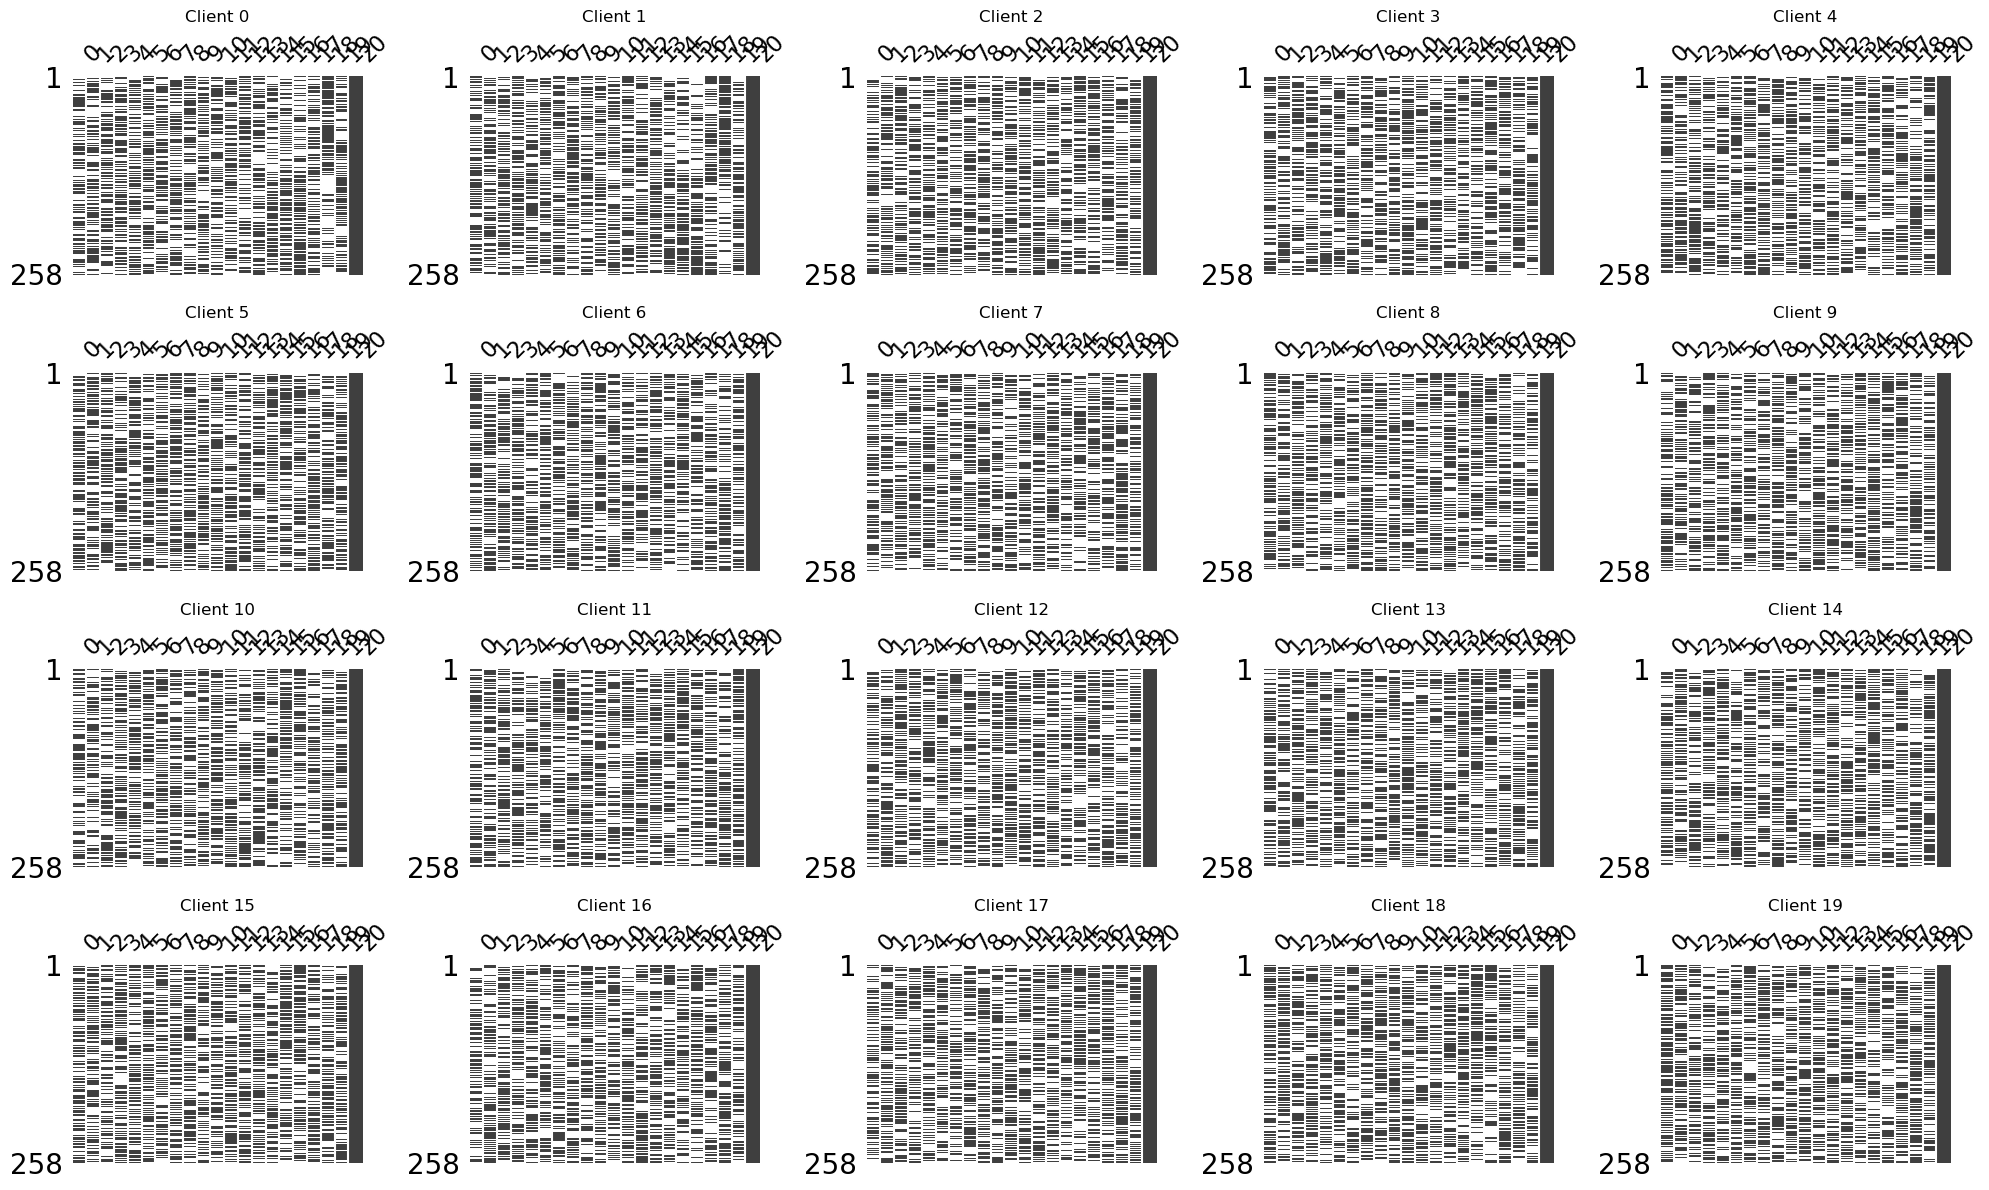

In [6]:
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 20
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme'
config2['data_partition']['strategy'] = 'sample@p=0.01'
config2['agg_strategy_imp']['strategy'] = 'fedavg-s'

configuration = config2
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients2 = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients2, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)
visualize_ms(data_ms_clients2)

### Simple Averaging

In [61]:
configuration['agg_strategy_imp']['strategy'] = 'fedavg-s'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret2 = server.run()

2023-07-19 09:25:13.651 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 101.76251480000792


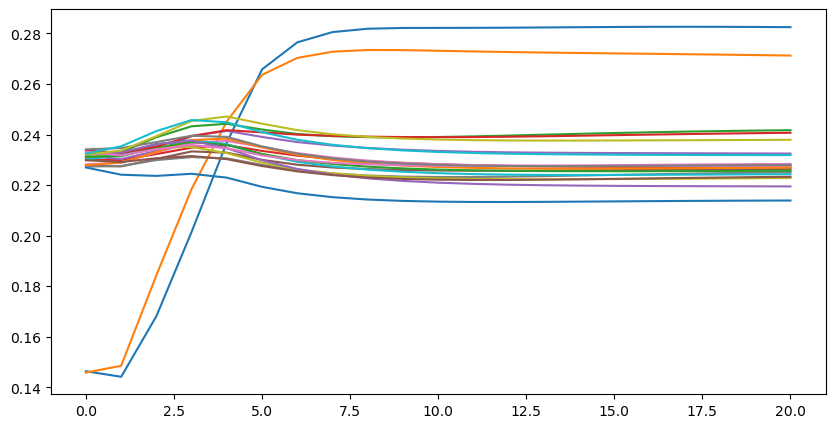

In [62]:
x = list(range(len(ret2['client_imp_history'])))
client_ids = list(ret2['client_imp_history'][0][2]['metrics'].keys())

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for client_id in client_ids:
    y = [ret2['client_imp_history'][i][2]['metrics'][client_id]['imp@rmse'] for i in x]
    ax.plot(x, y, label=client_id)
plt.show()

In [63]:
sklearn_evaluation(ret2)

Accuracy imputed centralized MLP:0.7875 (0.016)
Accuracy imputed centralized LR:0.8056 (0.000)
Accuracy orignal centralized MLP:0.9335 (0.003)
Accuracy orignal centralized MLP:0.8711 (0.000)


In [65]:
clients_ = {}
data_imp = ret2['data']['imputed_data']
missing_mask = ret2['data']['missing_mask']
data_true = ret2['data']['origin_data']
n_clients = ret2['data']['origin_data'].shape[0]
test_data = ret2['data']['test_data']
for client_id in range(n_clients):
    clients_[client_id] = SimpleClient(
        client_id=client_id,
        data_imp=data_imp[client_id],
        missing_mask=missing_mask[client_id],
        data_true=data_true[client_id],
        data_test=test_data
    )

pred_config = server_config_tmpl.copy()
server_name = 'fedavg_mlp_pytorch_pred'
server_pred_config = pred_config['server_pred_config']
server_pred_config['train_params']['pred_round'] = 1000
server_config = pred_config['server_config']
server_ = load_server(
        server_name, clients=clients_, server_config=server_config, pred_config=server_pred_config,
        test_data=test_data
    )

pred_ret2 = server.prediction()

2023-07-19 09:28:36.629 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:154 - Round: 50, test_accu: 0.7662, test_f1: 0.7657, val_loss: 0.6019, val_accu: 0.6462, val_f1: 0.6455
2023-07-19 09:29:03.612 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:154 - Round: 100, test_accu: 0.7636, test_f1: 0.7635, val_loss: 0.5723, val_accu: 0.6654, val_f1: 0.6651
2023-07-19 09:29:29.434 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:154 - Round: 150, test_accu: 0.7690, test_f1: 0.7689, val_loss: 0.5644, val_accu: 0.6673, val_f1: 0.6672
2023-07-19 09:29:55.311 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:154 - Round: 200, test_accu: 0.7784, test_f1: 0.7784, val_loss: 0.5641, val_accu: 0.6692, val_f1: 0.6687


### Complementary Models

In [13]:
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 20
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme'
config2['data_partition']['strategy'] = 'sample@p=0.01'
config2['agg_strategy_imp']['strategy'] = 'testavg2'

configuration = config2
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients2 = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients2, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)

sample {'p': '0.01'}
['mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right']


In [17]:
configuration['agg_strategy_imp']['strategy'] = 'testavg2'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret4 = server.run()

testavg2


2023-07-19 07:32:12.607 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 99.54026869998779


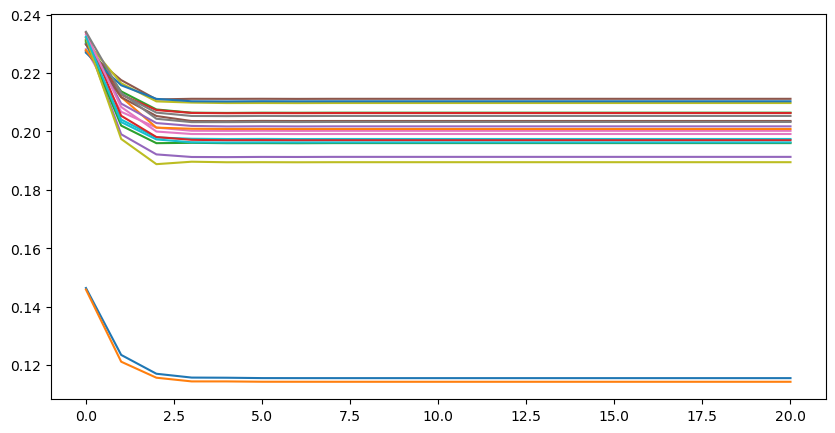

(5160, 21)
(5160, 21)
(11051, 21)


{'imp@rmse': 0.19274740995970174,
 'imp@ws': 0.8220250768697369,
 'imp@sliced_ws': 0.05713877131505986}

In [23]:
x = list(range(len(ret4['client_imp_history'])))
client_ids = list(ret4['client_imp_history'][0][2]['metrics'].keys())

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for client_id in client_ids:
    y = [ret4['client_imp_history'][i][2]['metrics'][client_id]['imp@rmse'] for i in x]
    ax.plot(x, y, label=client_id)
plt.show()

original_data4 = ret4['data']['origin_data'].reshape(-1, ret4['data']['origin_data'].shape[-1])
print(original_data4.shape)
centralized_data4 = ret4['data']['imputed_data'].reshape(-1, ret4['data']['imputed_data'].shape[-1])
print(centralized_data4.shape)
test_data4 = ret4['data']['test_data']
print(test_data4.shape)
ret4['imp_result']

In [24]:
sklearn_evaluation(ret4)

Accuracy imputed centralized MLP:0.8541 (0.017)
Accuracy imputed centralized LR:0.8467 (0.000)
Accuracy orignal centralized MLP:0.9335 (0.003)
Accuracy orignal centralized MLP:0.8711 (0.000)


In [42]:
clients_ = {}
data_imp2 = ret4['data']['imputed_data']
missing_mask2 = ret4['data']['missing_mask']
data_true2 = ret4['data']['origin_data']
n_clients = ret4['data']['origin_data'].shape[0]
for client_id in range(n_clients):
    clients_[client_id] = SimpleClient(
        client_id=client_id,
        data_imp=data_imp2[client_id],
        missing_mask=missing_mask2[client_id],
        data_true=data_true2[client_id],
        data_test=test_data4
    )

pred_config = server_config_tmpl.copy()
server_name = 'fedavg_mlp_pytorch_pred'
server_pred_config = pred_config['server_pred_config']
server_pred_config['train_params']['pred_round'] = 1000
server_config = pred_config['server_config']
server_ = load_server(
        server_name, clients=clients_, server_config=server_config, pred_config=server_pred_config,
        test_data=test_data4
    )

pred_ret2 = server_.prediction()

2023-07-19 02:52:00.793 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.8297, test_f1: 0.8296, val_loss: 0.5619, val_accu: 0.7192, val_f1: 0.7187
2023-07-19 02:53:38.154 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.8409, test_f1: 0.8409, val_loss: 0.5360, val_accu: 0.7330, val_f1: 0.7328
2023-07-19 02:55:16.488 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.8520, test_f1: 0.8519, val_loss: 0.5298, val_accu: 0.7394, val_f1: 0.7394
2023-07-19 02:56:53.952 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.8548, test_f1: 0.8546, val_loss: 0.5265, val_accu: 0.7401, val_f1: 0.7401
2023-07-19 02:58:31.282 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.8617, test_f1: 0.861

### Our Method

In [39]:
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 20
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme'
config2['data_partition']['strategy'] = 'sample@p=0.01'
config2['agg_strategy_imp']['strategy'] = 'fedmechw'

configuration = config2
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients2 = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients2, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)

sample {'p': '0.01'}
['mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right']


In [40]:
configuration['agg_strategy_imp']['strategy'] = 'fedmechw'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True
configuration['algo_params']["fedmechw"] = {
    "client_thres": 0.4,
    "alpha": 1.0,
    "beta": 0
}

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret9 = server.run()

2023-07-19 08:40:14.125 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 109.21593330003088


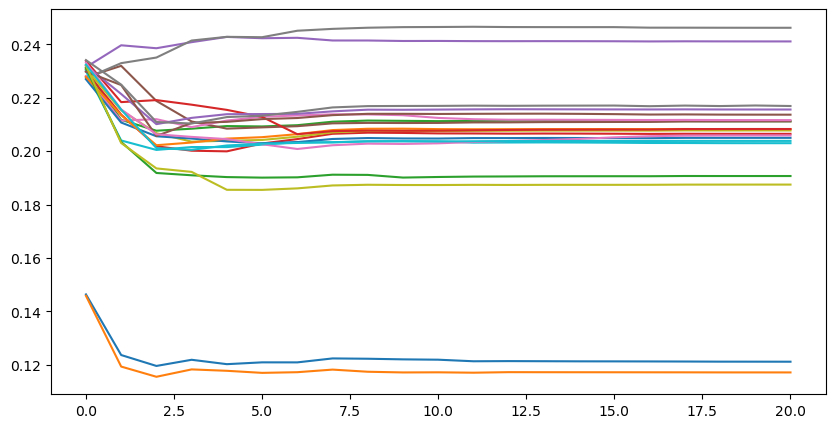

(5160, 21)
(5160, 21)
(11051, 21)


{'imp@rmse': 0.20163841366985513,
 'imp@ws': 0.9666018095870867,
 'imp@sliced_ws': 0.0652507117254917}

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for client_id in client_ids:
    y = [ret9['client_imp_history'][i][2]['metrics'][client_id]['imp@rmse'] for i in x]
    ax.plot(x, y, label=client_id)
plt.show()

original_data9 = ret9['data']['origin_data'].reshape(-1, ret9['data']['origin_data'].shape[-1])
print(original_data9.shape)
centralized_data9 = ret9['data']['imputed_data'].reshape(-1, ret9['data']['imputed_data'].shape[-1])
print(centralized_data4.shape)
test_data9 = ret9['data']['test_data']
print(test_data9.shape)
ret9['imp_result']

In [43]:
sklearn_evaluation(ret9)

Accuracy imputed centralized MLP:0.8113 (0.026)
Accuracy imputed centralized LR:0.8176 (0.000)
Accuracy orignal centralized MLP:0.9335 (0.003)
Accuracy orignal centralized MLP:0.8711 (0.000)


In [45]:
clients_ = {}
data_imp = ret9['data']['imputed_data']
missing_mask = ret9['data']['missing_mask']
data_true = ret9['data']['origin_data']
n_clients = ret9['data']['origin_data'].shape[0]
test_data = ret9['data']['test_data']
for client_id in range(n_clients):
    clients_[client_id] = SimpleClient(
        client_id=client_id,
        data_imp=data_imp[client_id],
        missing_mask=missing_mask[client_id],
        data_true=data_true[client_id],
        data_test=test_data
    )

pred_config = server_config_tmpl.copy()
server_name = 'fedavg_mlp_pytorch_pred'
server_pred_config = pred_config['server_pred_config']
server_pred_config['train_params']['pred_round'] = 1000
server_config = pred_config['server_config']
server_ = load_server(
        server_name, clients=clients_, server_config=server_config, pred_config=server_pred_config,
        test_data=test_data
    )

pred_ret2 = server_.prediction()

2023-07-19 08:45:22.275 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.7733, test_f1: 0.7713, val_loss: 0.5815, val_accu: 0.7029, val_f1: 0.7029
2023-07-19 08:46:02.047 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.8008, test_f1: 0.7994, val_loss: 0.5362, val_accu: 0.7106, val_f1: 0.7104
2023-07-19 08:46:40.222 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.8182, test_f1: 0.8175, val_loss: 0.5268, val_accu: 0.7212, val_f1: 0.7211
2023-07-19 08:47:19.003 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.8268, test_f1: 0.8264, val_loss: 0.5236, val_accu: 0.7298, val_f1: 0.7298
2023-07-19 08:47:58.036 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.8299, test_f1: 0.829

## MNAR RL

sample {'p': '0.01'}
['mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left']


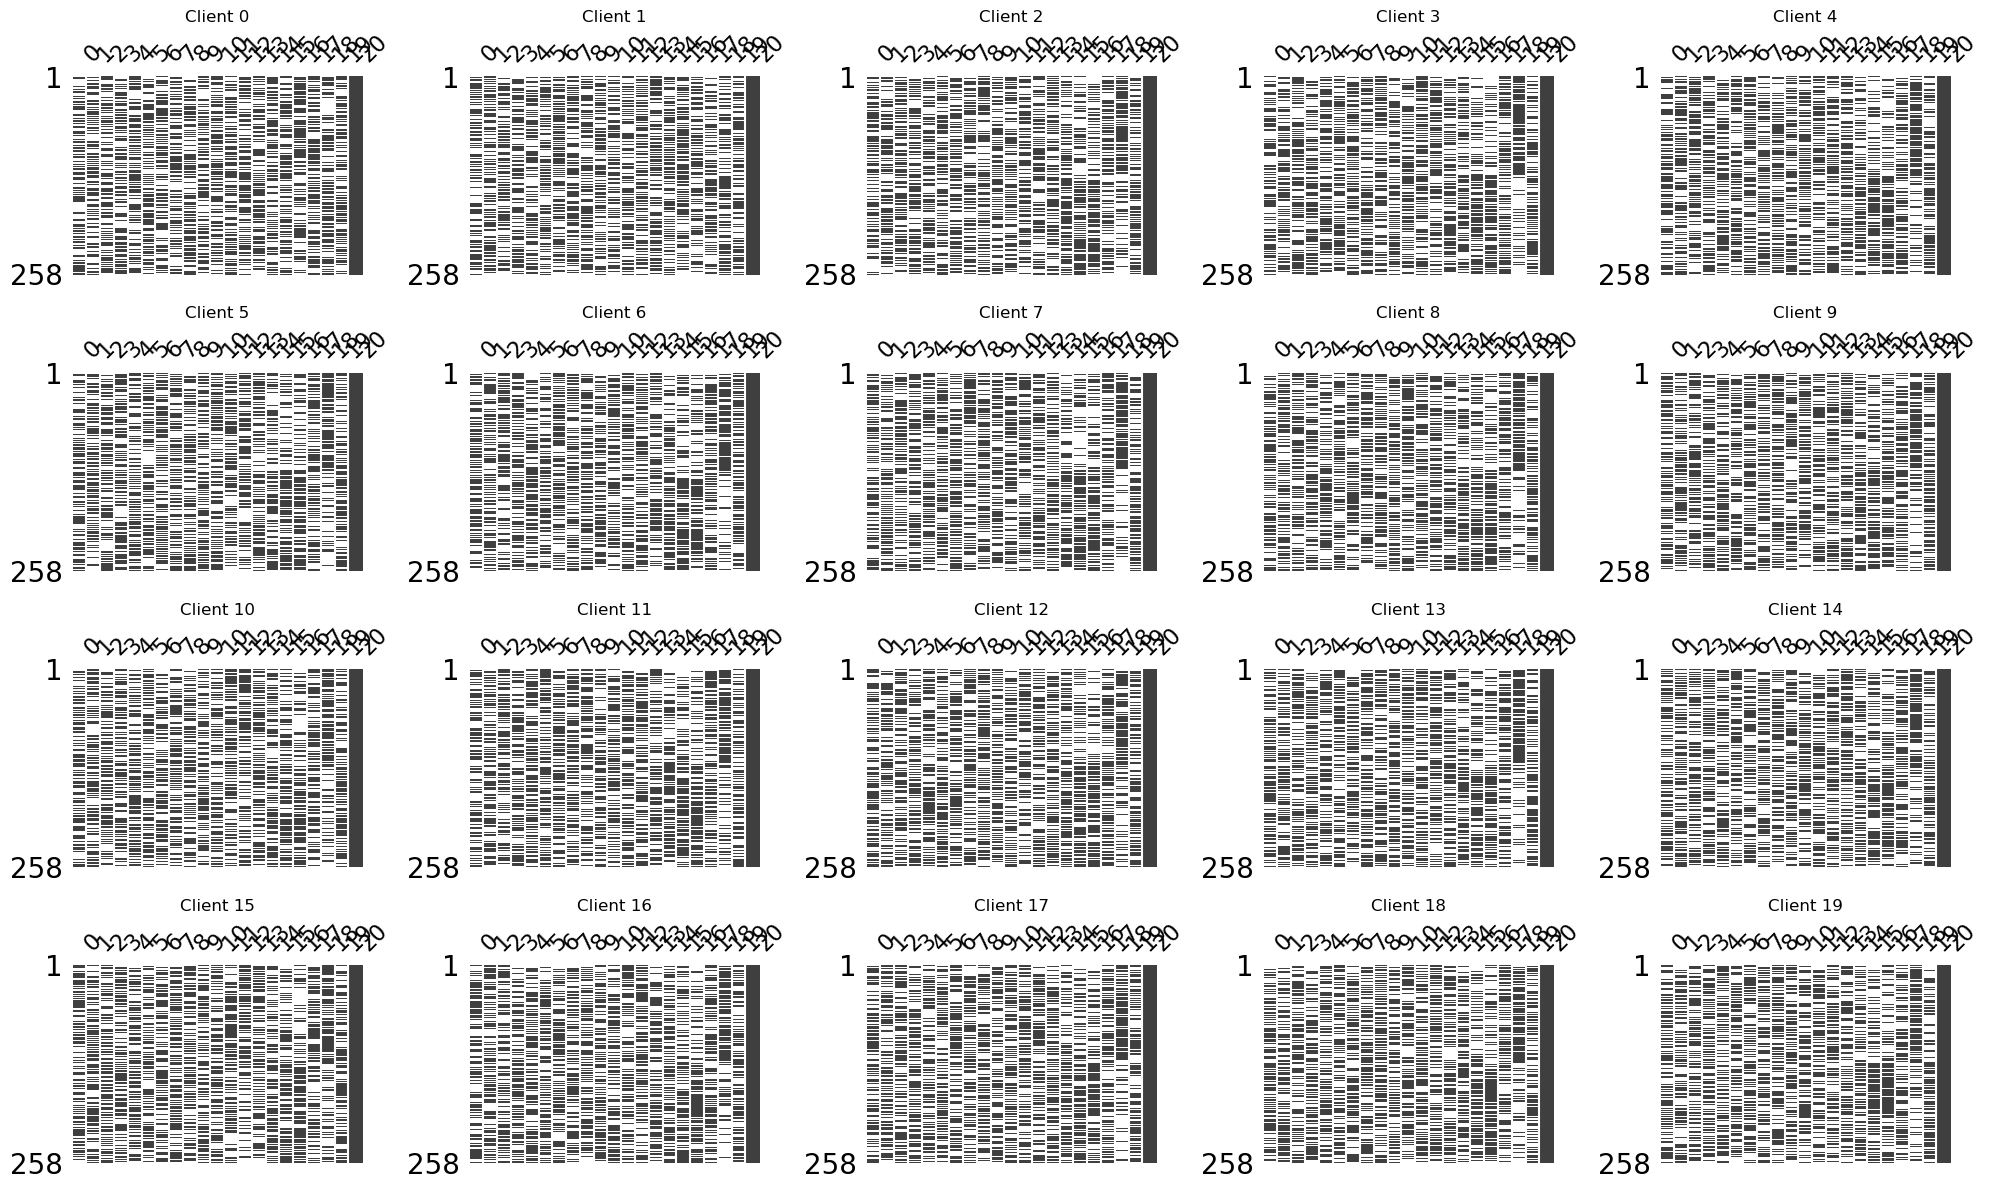

In [67]:
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 20
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_rl@sp=extreme'
config2['data_partition']['strategy'] = 'sample@p=0.01'
config2['agg_strategy_imp']['strategy'] = 'fedavg-s'

configuration = config2
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients2 = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients2, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)

visualize_ms(data_ms_clients2)

### Simple Averaging

In [68]:
configuration['agg_strategy_imp']['strategy'] = 'fedavg-s'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret5 = server.run()

2023-07-19 09:39:07.814 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 102.4134664000012


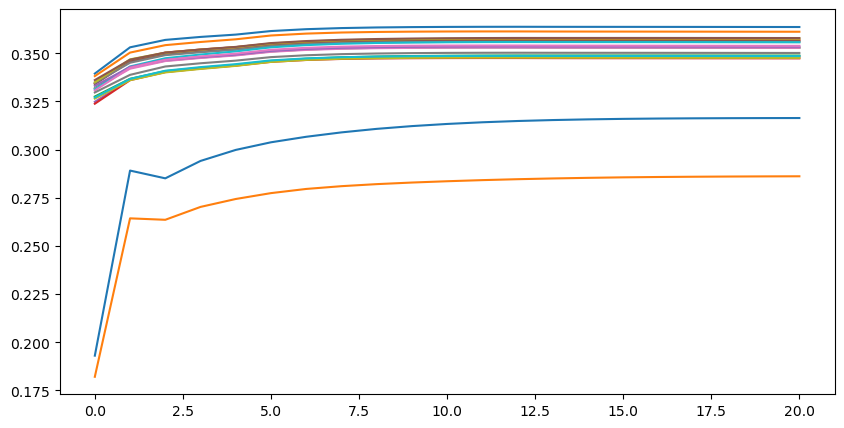

In [69]:
x = list(range(len(ret5['client_imp_history'])))
client_ids = list(ret5['client_imp_history'][0][2]['metrics'].keys())

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for client_id in client_ids:
    y = [ret5['client_imp_history'][i][2]['metrics'][client_id]['imp@rmse'] for i in x]
    ax.plot(x, y, label=client_id)
plt.show()

In [70]:
sklearn_evaluation(ret5)

Accuracy imputed centralized MLP:0.7014 (0.039)
Accuracy imputed centralized LR:0.7988 (0.000)
Accuracy orignal centralized MLP:0.9335 (0.003)
Accuracy orignal centralized MLP:0.8711 (0.000)


In [71]:
clients_ = {}
data_imp = ret5['data']['imputed_data']
missing_mask = ret5['data']['missing_mask']
data_true = ret5['data']['origin_data']
n_client = ret5['data']['origin_data'].shape[0]
test_data = ret5['data']['test_data']
for client_id in range(n_clients):
    clients_[client_id] = SimpleClient(
        client_id=client_id,
        data_imp=data_imp[client_id],
        missing_mask=missing_mask[client_id],
        data_true=data_true[client_id],
        data_test=test_data
    )

pred_config = server_config_tmpl.copy()
server_name = 'fedavg_mlp_pytorch_pred'
server_pred_config = pred_config['server_pred_config']
server_pred_config['train_params']['pred_round'] = 1000
server_config = pred_config['server_config']
server_ = load_server(
        server_name, clients=clients_, server_config=server_config, pred_config=server_pred_config,
        test_data=test_data
    )

pred_ret5 = server_.prediction()

2023-07-19 09:42:30.559 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.6611, test_f1: 0.6589, val_loss: 0.6815, val_accu: 0.6000, val_f1: 0.5966
2023-07-19 09:43:09.122 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.7392, test_f1: 0.7336, val_loss: 0.6450, val_accu: 0.6433, val_f1: 0.6403
2023-07-19 09:43:47.742 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.7366, test_f1: 0.7296, val_loss: 0.6323, val_accu: 0.6452, val_f1: 0.6413
2023-07-19 09:44:25.684 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.7431, test_f1: 0.7367, val_loss: 0.6263, val_accu: 0.6548, val_f1: 0.6535
2023-07-19 09:45:04.481 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.7385, test_f1: 0.732

### Complementary Models without exchanging initialization

In [50]:
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 20
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_rl@sp=extreme'
config2['data_partition']['strategy'] = 'sample@p=0.01'
config2['agg_strategy_imp']['strategy'] = 'testavg2'

configuration = config2
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients2 = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients2, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)

sample {'p': '0.01'}
['mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left']


In [27]:
configuration['agg_strategy_imp']['strategy'] = 'testavg2'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret6 = server.run()

testavg2


2023-07-19 07:36:58.168 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 94.54939699999522


(5160, 21)
(5160, 21)
(11051, 21)
{'imp@rmse': 0.13098316570599958, 'imp@ws': 0.8198898750237007, 'imp@sliced_ws': 0.0694878123751296}


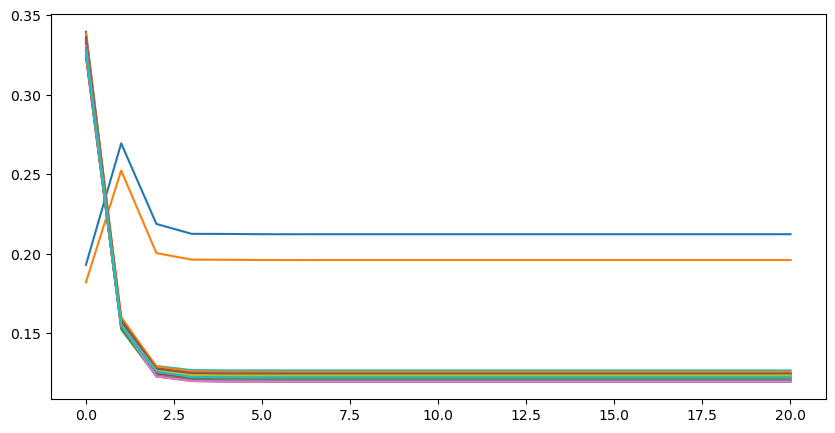

In [29]:
original_data6 = ret6['data']['origin_data'].reshape(-1, ret6['data']['origin_data'].shape[-1])
print(original_data6.shape)
centralized_data6 = ret6['data']['imputed_data'].reshape(-1, ret6['data']['imputed_data'].shape[-1])
print(centralized_data6.shape)
test_data6 = ret6['data']['test_data']
print(test_data6.shape)
print(ret6['imp_result'])

x = list(range(len(ret6['client_imp_history'])))
client_ids = list(ret6['client_imp_history'][0][2]['metrics'].keys())

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for client_id in client_ids:
    y = [ret6['client_imp_history'][i][2]['metrics'][client_id]['imp@rmse'] for i in x]
    ax.plot(x, y, label=client_id)
plt.show()

In [30]:
sklearn_evaluation(ret6)

Accuracy imputed centralized MLP:0.8684 (0.022)
Accuracy imputed centralized LR:0.8697 (0.000)
Accuracy orignal centralized MLP:0.9335 (0.003)
Accuracy orignal centralized MLP:0.8711 (0.000)


In [57]:
clients_ = {}
data_imp = ret6['data']['imputed_data']
missing_mask = ret6['data']['missing_mask']
data_true = ret6['data']['origin_data']
n_clients = ret6['data']['origin_data'].shape[0]
test_data = ret6['data']['test_data']
for client_id in range(n_clients):
    clients_[client_id] = SimpleClient(
        client_id=client_id,
        data_imp=data_imp[client_id],
        missing_mask=missing_mask[client_id],
        data_true=data_true[client_id],
        data_test=test_data
    )

pred_config = server_config_tmpl.copy()
server_name = 'fedavg_mlp_pytorch_pred'
server_pred_config = pred_config['server_pred_config']
server_pred_config['train_params']['pred_round'] = 1000
server_config = pred_config['server_config']
server_ = load_server(
        server_name, clients=clients_, server_config=server_config, pred_config=server_pred_config,
        test_data=test_data
    )

pred_ret6 = server_.prediction()

2023-07-19 06:46:04.438 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.7985, test_f1: 0.7975, val_loss: 0.5299, val_accu: 0.7490, val_f1: 0.7455
2023-07-19 06:46:45.293 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.8440, test_f1: 0.8439, val_loss: 0.4700, val_accu: 0.7808, val_f1: 0.7790
2023-07-19 06:47:29.234 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.8500, test_f1: 0.8500, val_loss: 0.4531, val_accu: 0.7962, val_f1: 0.7950
2023-07-19 06:48:11.901 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.8526, test_f1: 0.8526, val_loss: 0.4443, val_accu: 0.8048, val_f1: 0.8042
2023-07-19 06:48:54.407 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.8549, test_f1: 0.854

### Our Method

In [29]:
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 20
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_rl@sp=extreme'
config2['data_partition']['strategy'] = 'sample@p=0.01'
config2['agg_strategy_imp']['strategy'] = 'fedmechw'

configuration = config2
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients2 = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients2, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)

sample {'p': '0.01'}
['mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left']


In [30]:
configuration['agg_strategy_imp']['strategy'] = 'fedmechw'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True
configuration['algo_params']["fedmechw"] = {
    "client_thres": 1.0,
    "alpha": 1.0,
    "beta": 0
}
configuration['algo_params']["scale_factor"] = 2

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret10 = server.run()

2023-07-19 12:58:21.944 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 100.41061349998927


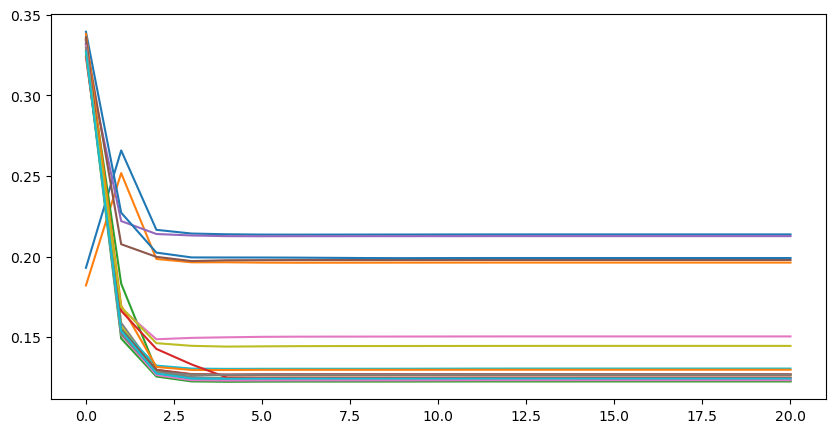

{'imp@rmse': 0.14743569133332302,
 'imp@ws': 0.889747684811652,
 'imp@sliced_ws': 0.07753575932703871}

In [31]:
x = list(range(len(ret10['client_imp_history'])))
client_ids = list(ret10['client_imp_history'][0][2]['metrics'].keys())
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for client_id in client_ids:
    y = [ret10['client_imp_history'][i][2]['metrics'][client_id]['imp@rmse'] for i in x]
    ax.plot(x, y, label=client_id)
plt.show()

ret10['imp_result']

In [57]:
sklearn_evaluation(ret10)

Accuracy imputed centralized MLP:0.8589 (0.022)
Accuracy imputed centralized LR:0.8722 (0.000)
Accuracy orignal centralized MLP:0.9335 (0.003)
Accuracy orignal centralized MLP:0.8711 (0.000)


In [58]:
clients_ = {}
data_imp = ret10['data']['imputed_data']
missing_mask = ret10['data']['missing_mask']
data_true = ret10['data']['origin_data']
n_clients = ret10['data']['origin_data'].shape[0]
test_data = ret10['data']['test_data']
for client_id in range(n_clients):
    clients_[client_id] = SimpleClient(
        client_id=client_id,
        data_imp=data_imp[client_id],
        missing_mask=missing_mask[client_id],
        data_true=data_true[client_id],
        data_test=test_data
    )

pred_config = server_config_tmpl.copy()
server_name = 'fedavg_mlp_pytorch_pred'
server_pred_config = pred_config['server_pred_config']
server_pred_config['train_params']['pred_round'] = 1000
server_config = pred_config['server_config']
server_ = load_server(
        server_name, clients=clients_, server_config=server_config, pred_config=server_pred_config,
        test_data=test_data
    )

pred_ret2 = server_.prediction()

2023-07-19 09:07:52.502 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.8014, test_f1: 0.8013, val_loss: 0.5364, val_accu: 0.7423, val_f1: 0.7391
2023-07-19 09:08:30.196 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.8416, test_f1: 0.8416, val_loss: 0.4812, val_accu: 0.7702, val_f1: 0.7684
2023-07-19 09:09:08.298 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.8473, test_f1: 0.8472, val_loss: 0.4659, val_accu: 0.7779, val_f1: 0.7764
2023-07-19 09:09:47.071 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.8489, test_f1: 0.8488, val_loss: 0.4586, val_accu: 0.7846, val_f1: 0.7836
2023-07-19 09:10:24.968 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.8478, test_f1: 0.847

## MARY Sigmoid - more patterns

sample {'p': '0.01'}
['mary_sigmoid_left' 'mary_sigmoid_left' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right']


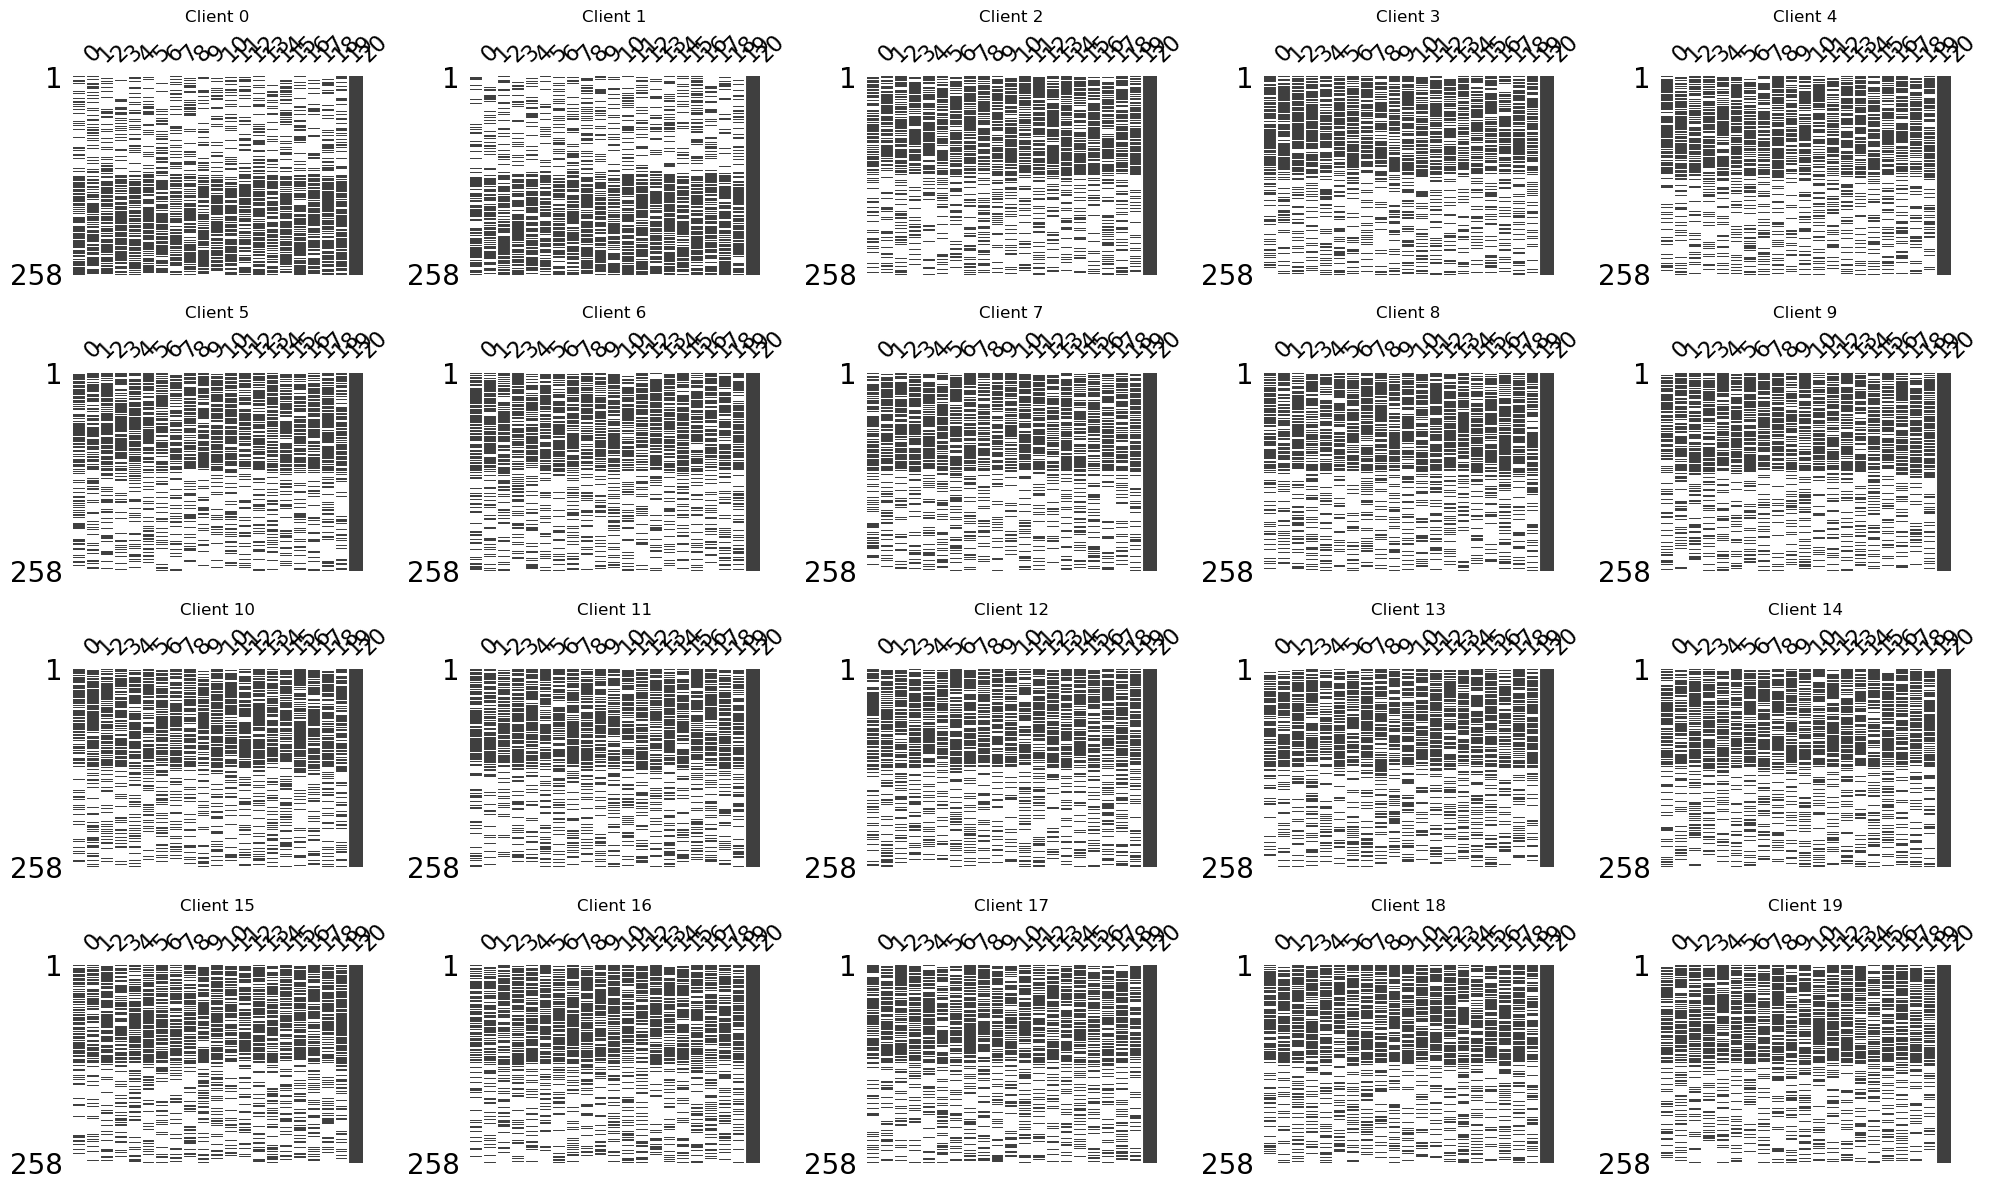

In [72]:
config = experiment_config_template.copy()
config['data']['dataset_name'] = 'ijcnn_balanced_pca'
config['num_clients'] = 20
config['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config['missing_simulate']['mf_strategy'] = 'all'
config['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme'
config['data_partition']['strategy'] = 'sample@p=0.01'

configuration = config
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)
visualize_ms(data_ms_clients)

### Simple Averaging

In [32]:
configuration['agg_strategy_imp']['strategy'] = 'fedavg-s'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret7 = server.run()

2023-07-19 07:40:59.514 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 101.5302159000421


(5160, 21)
(5160, 21)
(11051, 21)
{'imp@rmse': 0.1980545640120416, 'imp@ws': 1.3905617092525906, 'imp@sliced_ws': 0.06800155583649194}


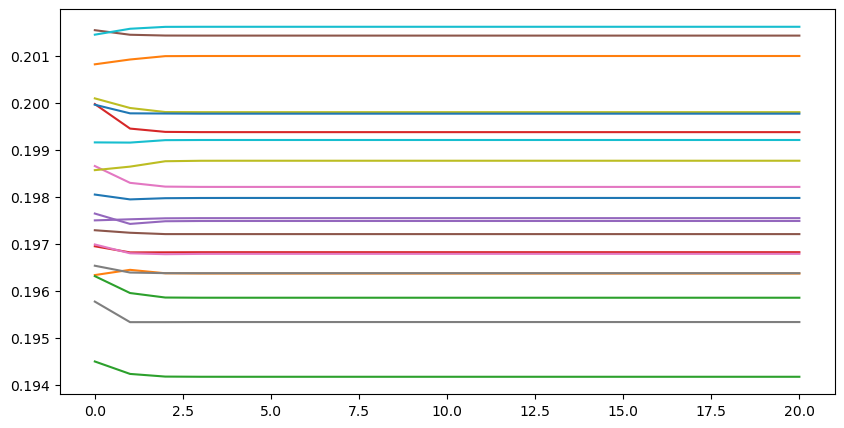

In [73]:
original_data7 = ret7['data']['origin_data'].reshape(-1, ret7['data']['origin_data'].shape[-1])
print(original_data7.shape)
centralized_data7 = ret7['data']['imputed_data'].reshape(-1, ret7['data']['imputed_data'].shape[-1])
print(centralized_data7.shape)
test_data7 = ret7['data']['test_data']
print(test_data7.shape)
print(ret7['imp_result'])

x = list(range(len(ret7['client_imp_history'])))
client_ids = list(ret7['client_imp_history'][0][2]['metrics'].keys())

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for client_id in client_ids:
    y = [ret7['client_imp_history'][i][2]['metrics'][client_id]['imp@rmse'] for i in x]
    ax.plot(x, y, label=client_id)
plt.show()

In [74]:
sklearn_evaluation(ret7)

Accuracy imputed centralized MLP:0.6428 (0.013)
Accuracy imputed centralized LR:0.8374 (0.000)
Accuracy orignal centralized MLP:0.9335 (0.003)
Accuracy orignal centralized MLP:0.8711 (0.000)


In [75]:
clients_ = {}
data_imp = ret7['data']['imputed_data']
missing_mask = ret7['data']['missing_mask']
data_true = ret7['data']['origin_data']
n_client = ret7['data']['origin_data'].shape[0]
test_data = ret7['data']['test_data']
for client_id in range(n_clients):
    clients_[client_id] = SimpleClient(
        client_id=client_id,
        data_imp=data_imp[client_id],
        missing_mask=missing_mask[client_id],
        data_true=data_true[client_id],
        data_test=test_data
    )

pred_config = server_config_tmpl.copy()
server_name = 'fedavg_mlp_pytorch_pred'
server_pred_config = pred_config['server_pred_config']
server_pred_config['train_params']['pred_round'] = 500
server_config = pred_config['server_config']
server_ = load_server(
        server_name, clients=clients_, server_config=server_config, pred_config=server_pred_config,
        test_data=test_data
    )

pred_ret7 = server_.prediction()

2023-07-19 09:56:33.065 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.5714, test_f1: 0.4807, val_loss: 0.4668, val_accu: 0.7817, val_f1: 0.7816
2023-07-19 09:57:14.495 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.6018, test_f1: 0.5319, val_loss: 0.4195, val_accu: 0.8058, val_f1: 0.8055
2023-07-19 09:57:53.584 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.6040, test_f1: 0.5361, val_loss: 0.4103, val_accu: 0.8183, val_f1: 0.8180
2023-07-19 09:58:33.374 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.6021, test_f1: 0.5331, val_loss: 0.4067, val_accu: 0.8308, val_f1: 0.8305
2023-07-19 09:59:12.744 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.5963, test_f1: 0.522

### Complementary models

sample {'p': '0.01'}
['mary_sigmoid_left' 'mary_sigmoid_left' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right']


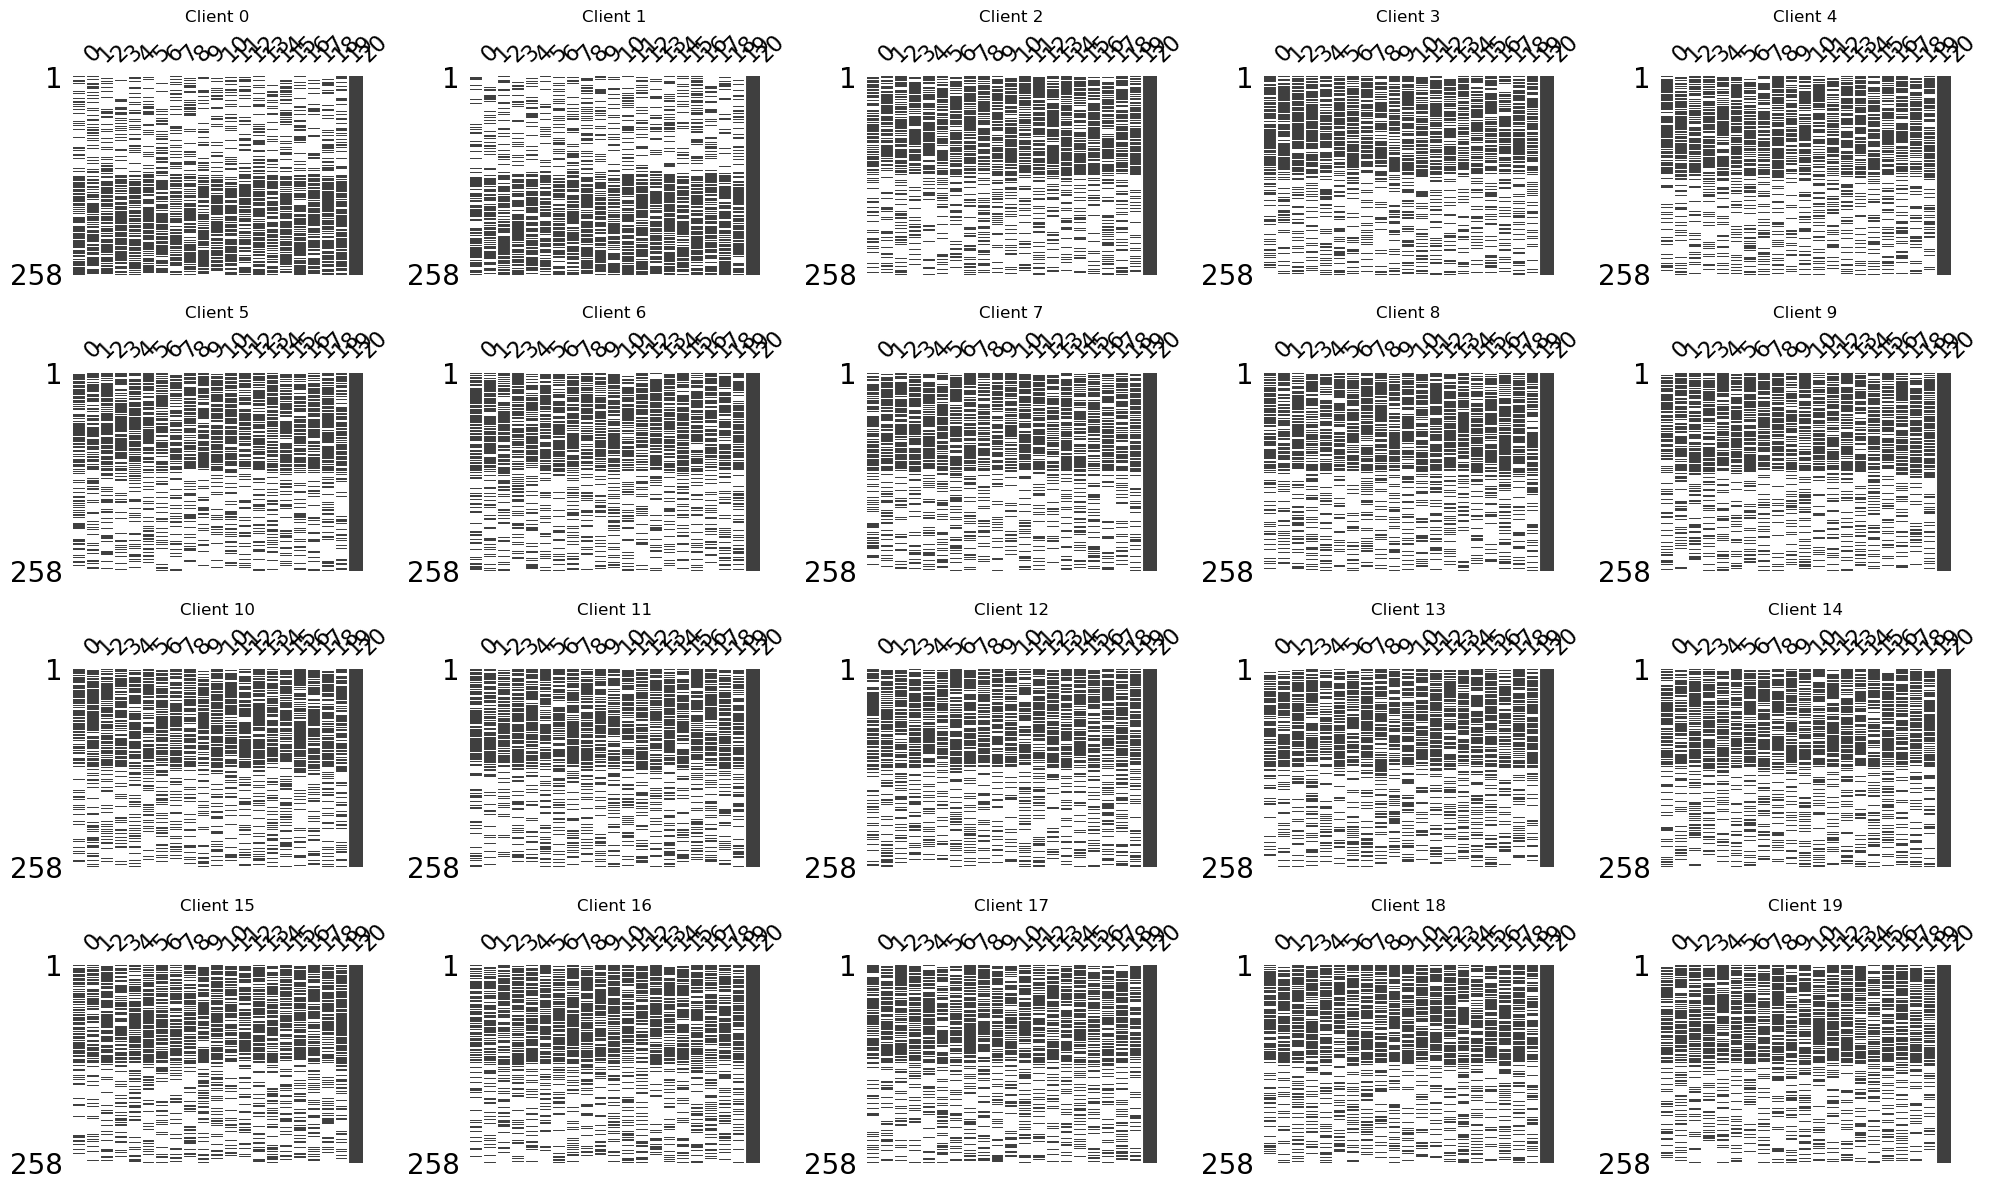

In [79]:
config = experiment_config_template.copy()
config['data']['dataset_name'] = 'ijcnn_balanced_pca'
config['num_clients'] = 20
config['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config['missing_simulate']['mf_strategy'] = 'all'
config['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme'
config['data_partition']['strategy'] = 'sample@p=0.01'

configuration = config
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)
visualize_ms(data_ms_clients)

In [80]:
configuration['agg_strategy_imp']['strategy'] = 'testavg2'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret8 = server.run()

testavg2


2023-07-19 10:04:55.344 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 100.81132959999377


(5160, 21)
(5160, 21)
(11051, 21)
{'imp@rmse': 0.1996548858509103, 'imp@ws': 1.26426648376057, 'imp@sliced_ws': 0.06677104963305082}


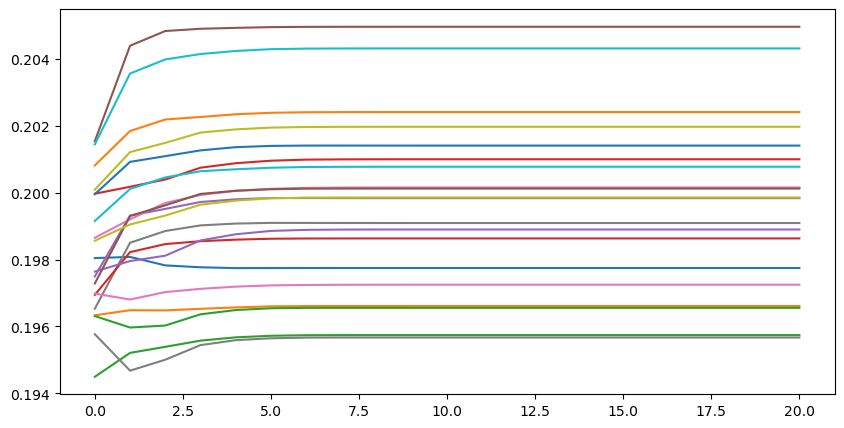

In [81]:
original_data8 = ret8['data']['origin_data'].reshape(-1, ret8['data']['origin_data'].shape[-1])
print(original_data8.shape)
centralized_data8 = ret8['data']['imputed_data'].reshape(-1, ret8['data']['imputed_data'].shape[-1])
print(centralized_data8.shape)
test_data8 = ret8['data']['test_data']
print(test_data8.shape)
print(ret8['imp_result'])

x = list(range(len(ret8['client_imp_history'])))
client_ids = list(ret8['client_imp_history'][0][2]['metrics'].keys())

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for client_id in client_ids:
    y = [ret8['client_imp_history'][i][2]['metrics'][client_id]['imp@rmse'] for i in x]
    ax.plot(x, y, label=client_id)
plt.show()

In [82]:
sklearn_evaluation(ret8)

Accuracy imputed centralized MLP:0.6273 (0.015)
Accuracy imputed centralized LR:0.8340 (0.000)
Accuracy orignal centralized MLP:0.9335 (0.003)
Accuracy orignal centralized MLP:0.8711 (0.000)


In [84]:
clients_ = {}
data_imp = ret8['data']['imputed_data']
missing_mask = ret8['data']['missing_mask']
data_true = ret8['data']['origin_data']
n_client = ret8['data']['origin_data'].shape[0]
test_data = ret8['data']['test_data']
for client_id in range(n_clients):
    clients_[client_id] = SimpleClient(
        client_id=client_id,
        data_imp=data_imp[client_id],
        missing_mask=missing_mask[client_id],
        data_true=data_true[client_id],
        data_test=test_data
    )

pred_config = server_config_tmpl.copy()
server_name = 'fedavg_mlp_pytorch_pred'
server_pred_config = pred_config['server_pred_config']
server_pred_config['train_params']['pred_round'] = 500
server_config = pred_config['server_config']
server_ = load_server(
        server_name, clients=clients_, server_config=server_config, pred_config=server_pred_config,
        test_data=test_data
    )

pred_ret8 = server_.prediction()

2023-07-19 10:08:25.350 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.5934, test_f1: 0.5212, val_loss: 0.4161, val_accu: 0.8163, val_f1: 0.8163
2023-07-19 10:09:01.946 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.6116, test_f1: 0.5467, val_loss: 0.3697, val_accu: 0.8317, val_f1: 0.8314
2023-07-19 10:09:37.857 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.6151, test_f1: 0.5520, val_loss: 0.3569, val_accu: 0.8394, val_f1: 0.8391
2023-07-19 10:10:14.146 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.6091, test_f1: 0.5416, val_loss: 0.3519, val_accu: 0.8442, val_f1: 0.8438
2023-07-19 10:10:53.064 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.5961, test_f1: 0.519

### Our Method

sample {'p': '0.01'}
['mary_sigmoid_left' 'mary_sigmoid_left' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right']


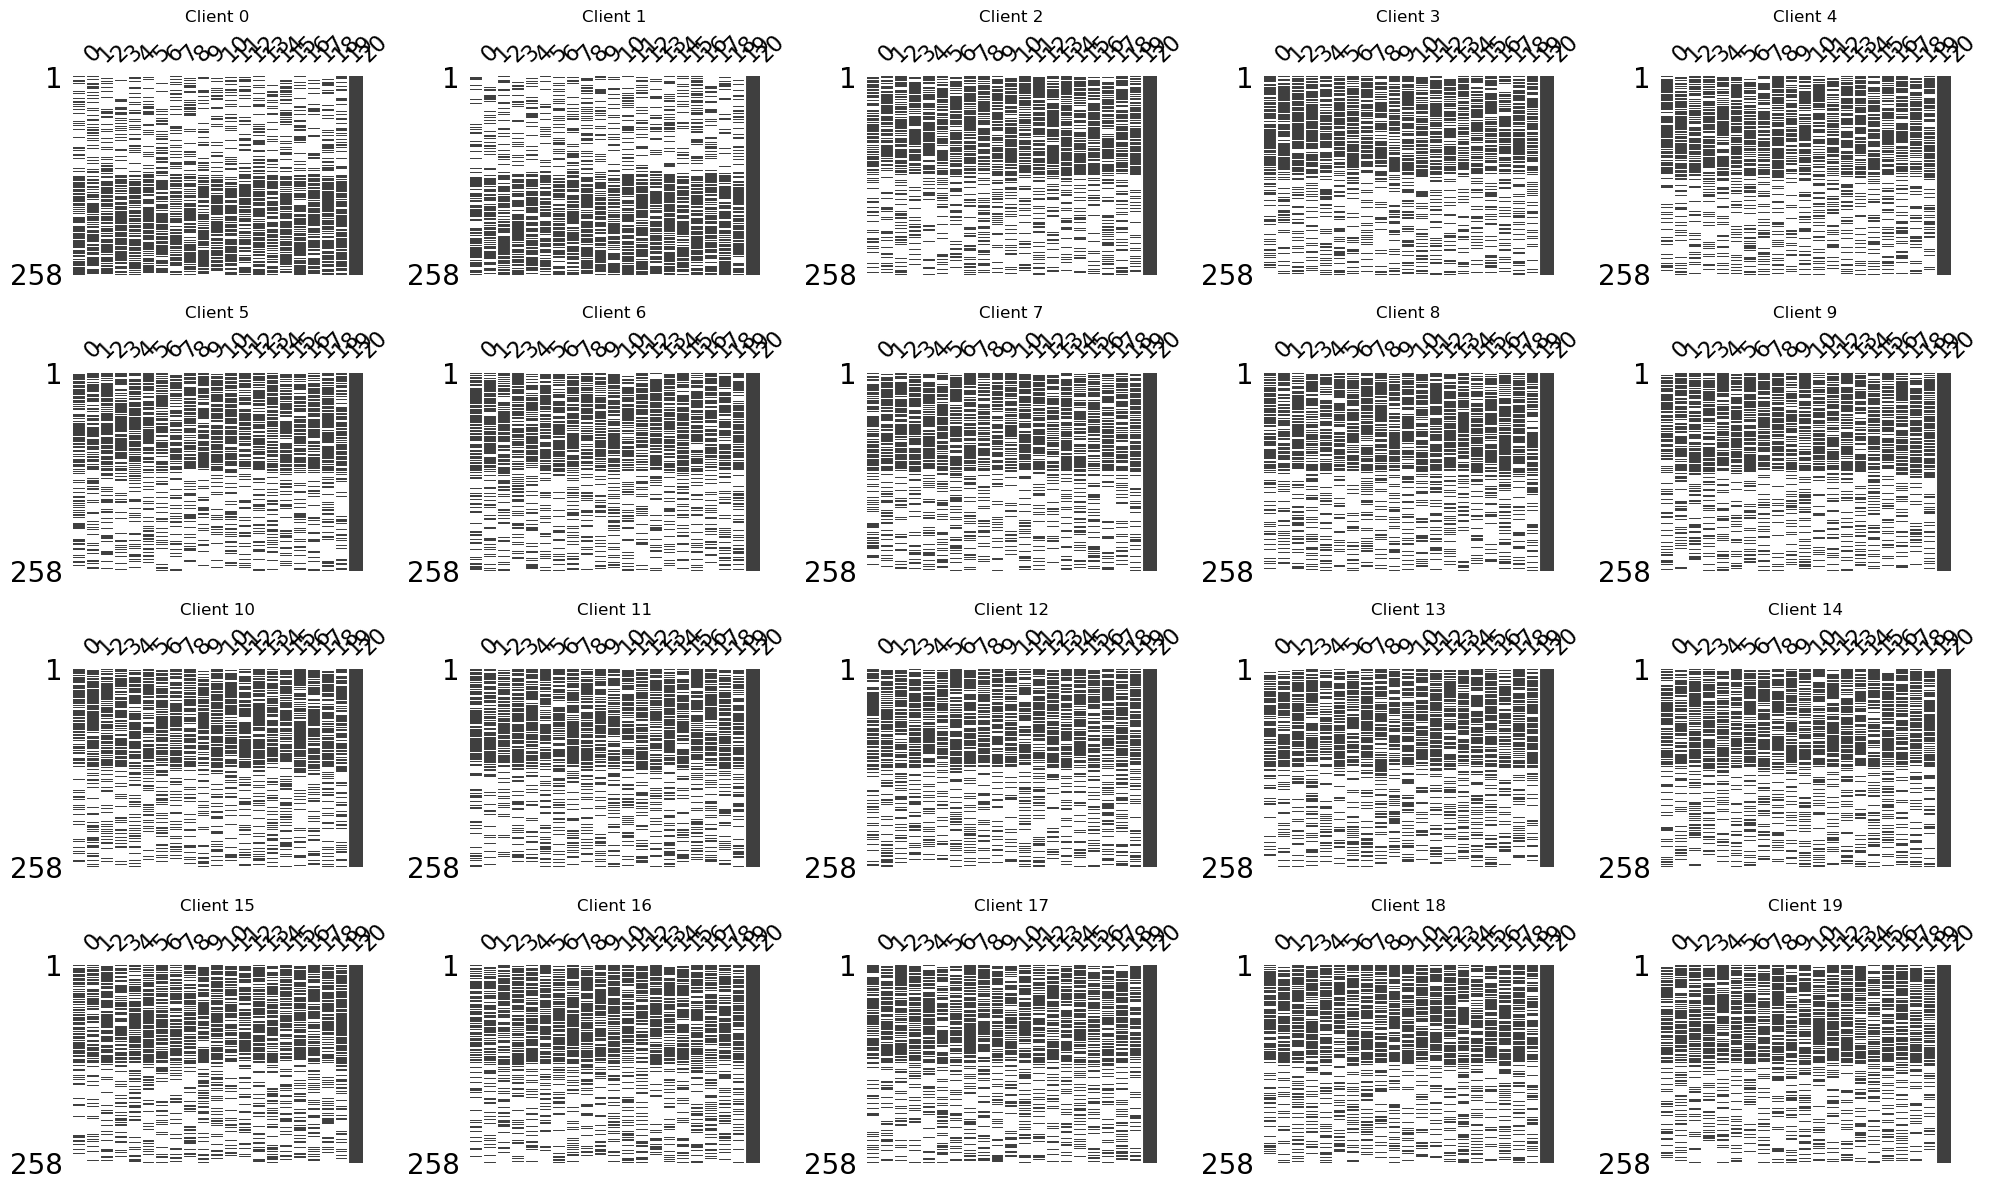

In [85]:
config = experiment_config_template.copy()
config['data']['dataset_name'] = 'ijcnn_balanced_pca'
config['num_clients'] = 20
config['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config['missing_simulate']['mf_strategy'] = 'all'
config['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme'
config['data_partition']['strategy'] = 'sample@p=0.01'

configuration = config
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)
visualize_ms(data_ms_clients)

In [87]:
configuration['agg_strategy_imp']['strategy'] = 'fedmechw'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True

configuration['algo_params']["fedmechw"] = {
    "client_thres": 0.4,
    "alpha": 1.0,
    "beta": 0
}

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret12 = server.run()

2023-07-19 10:15:53.216 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 104.08802470000228


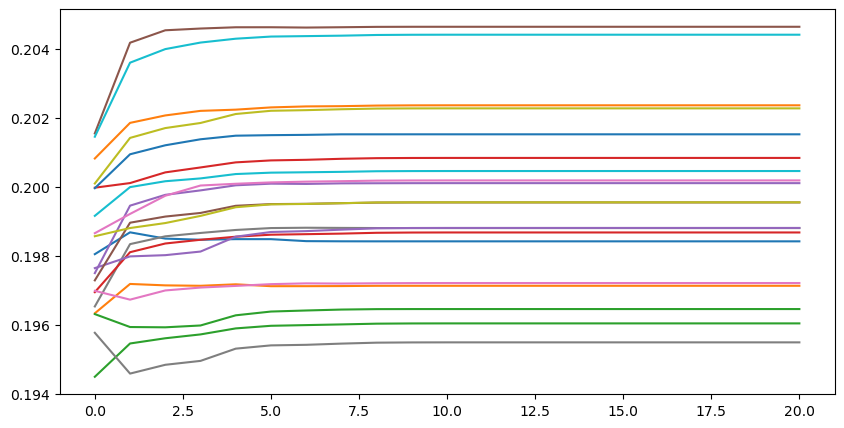

{'imp@rmse': 0.19964533072926968,
 'imp@ws': 1.2664797670349441,
 'imp@sliced_ws': 0.06620466545599235}

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for client_id in client_ids:
    y = [ret12['client_imp_history'][i][2]['metrics'][client_id]['imp@rmse'] for i in x]
    ax.plot(x, y, label=client_id)
plt.show()

ret12['imp_result']

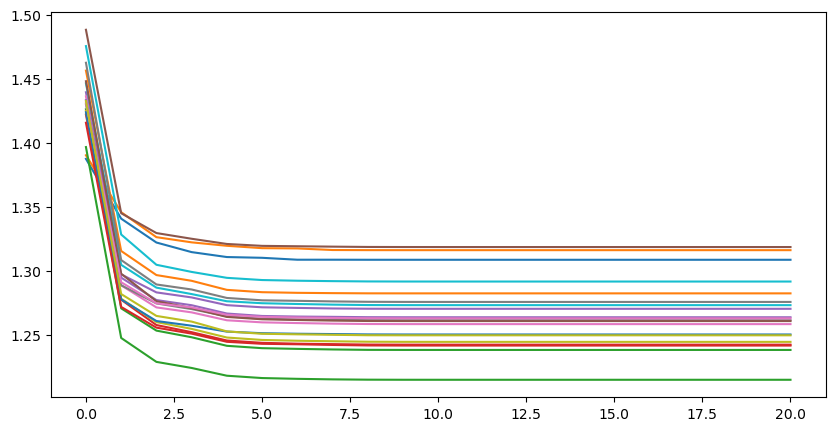

{'imp@rmse': 0.19964533072926968,
 'imp@ws': 1.2664797670349441,
 'imp@sliced_ws': 0.06620466545599235}

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for client_id in client_ids:
    y = [ret12['client_imp_history'][i][2]['metrics'][client_id]['imp@w2'] for i in x]
    ax.plot(x, y, label=client_id)
plt.show()

ret12['imp_result']

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for client_id in client_ids:
    y = [ret12['client_imp_history'][i][2]['metrics'][client_id]['imp@sliced_'] for i in x]
    ax.plot(x, y, label=client_id)
plt.show()

ret12['imp_result']

In [89]:
clients_ = {}
data_imp = ret12['data']['imputed_data']
missing_mask = ret12['data']['missing_mask']
data_true = ret12['data']['origin_data']
n_client = ret12['data']['origin_data'].shape[0]
test_data = ret12['data']['test_data']
for client_id in range(n_clients):
    clients_[client_id] = SimpleClient(
        client_id=client_id,
        data_imp=data_imp[client_id],
        missing_mask=missing_mask[client_id],
        data_true=data_true[client_id],
        data_test=test_data
    )

pred_config = server_config_tmpl.copy()
server_name = 'fedavg_mlp_pytorch_pred'
server_pred_config = pred_config['server_pred_config']
server_pred_config['train_params']['pred_round'] = 500
server_config = pred_config['server_config']
server_ = load_server(
        server_name, clients=clients_, server_config=server_config, pred_config=server_pred_config,
        test_data=test_data
    )

pred_ret8 = server_.prediction()

2023-07-19 10:16:31.428 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.5978, test_f1: 0.5278, val_loss: 0.4120, val_accu: 0.8202, val_f1: 0.8201
2023-07-19 10:17:07.093 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.6108, test_f1: 0.5458, val_loss: 0.3640, val_accu: 0.8346, val_f1: 0.8345
2023-07-19 10:17:44.731 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.6123, test_f1: 0.5477, val_loss: 0.3509, val_accu: 0.8423, val_f1: 0.8421
2023-07-19 10:18:23.222 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.6040, test_f1: 0.5331, val_loss: 0.3423, val_accu: 0.8452, val_f1: 0.8451
2023-07-19 10:19:03.200 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.6100, test_f1: 0.542

## MARY Quantile

sample {'p': '0.01'}
['mary_left' 'mary_left' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right']


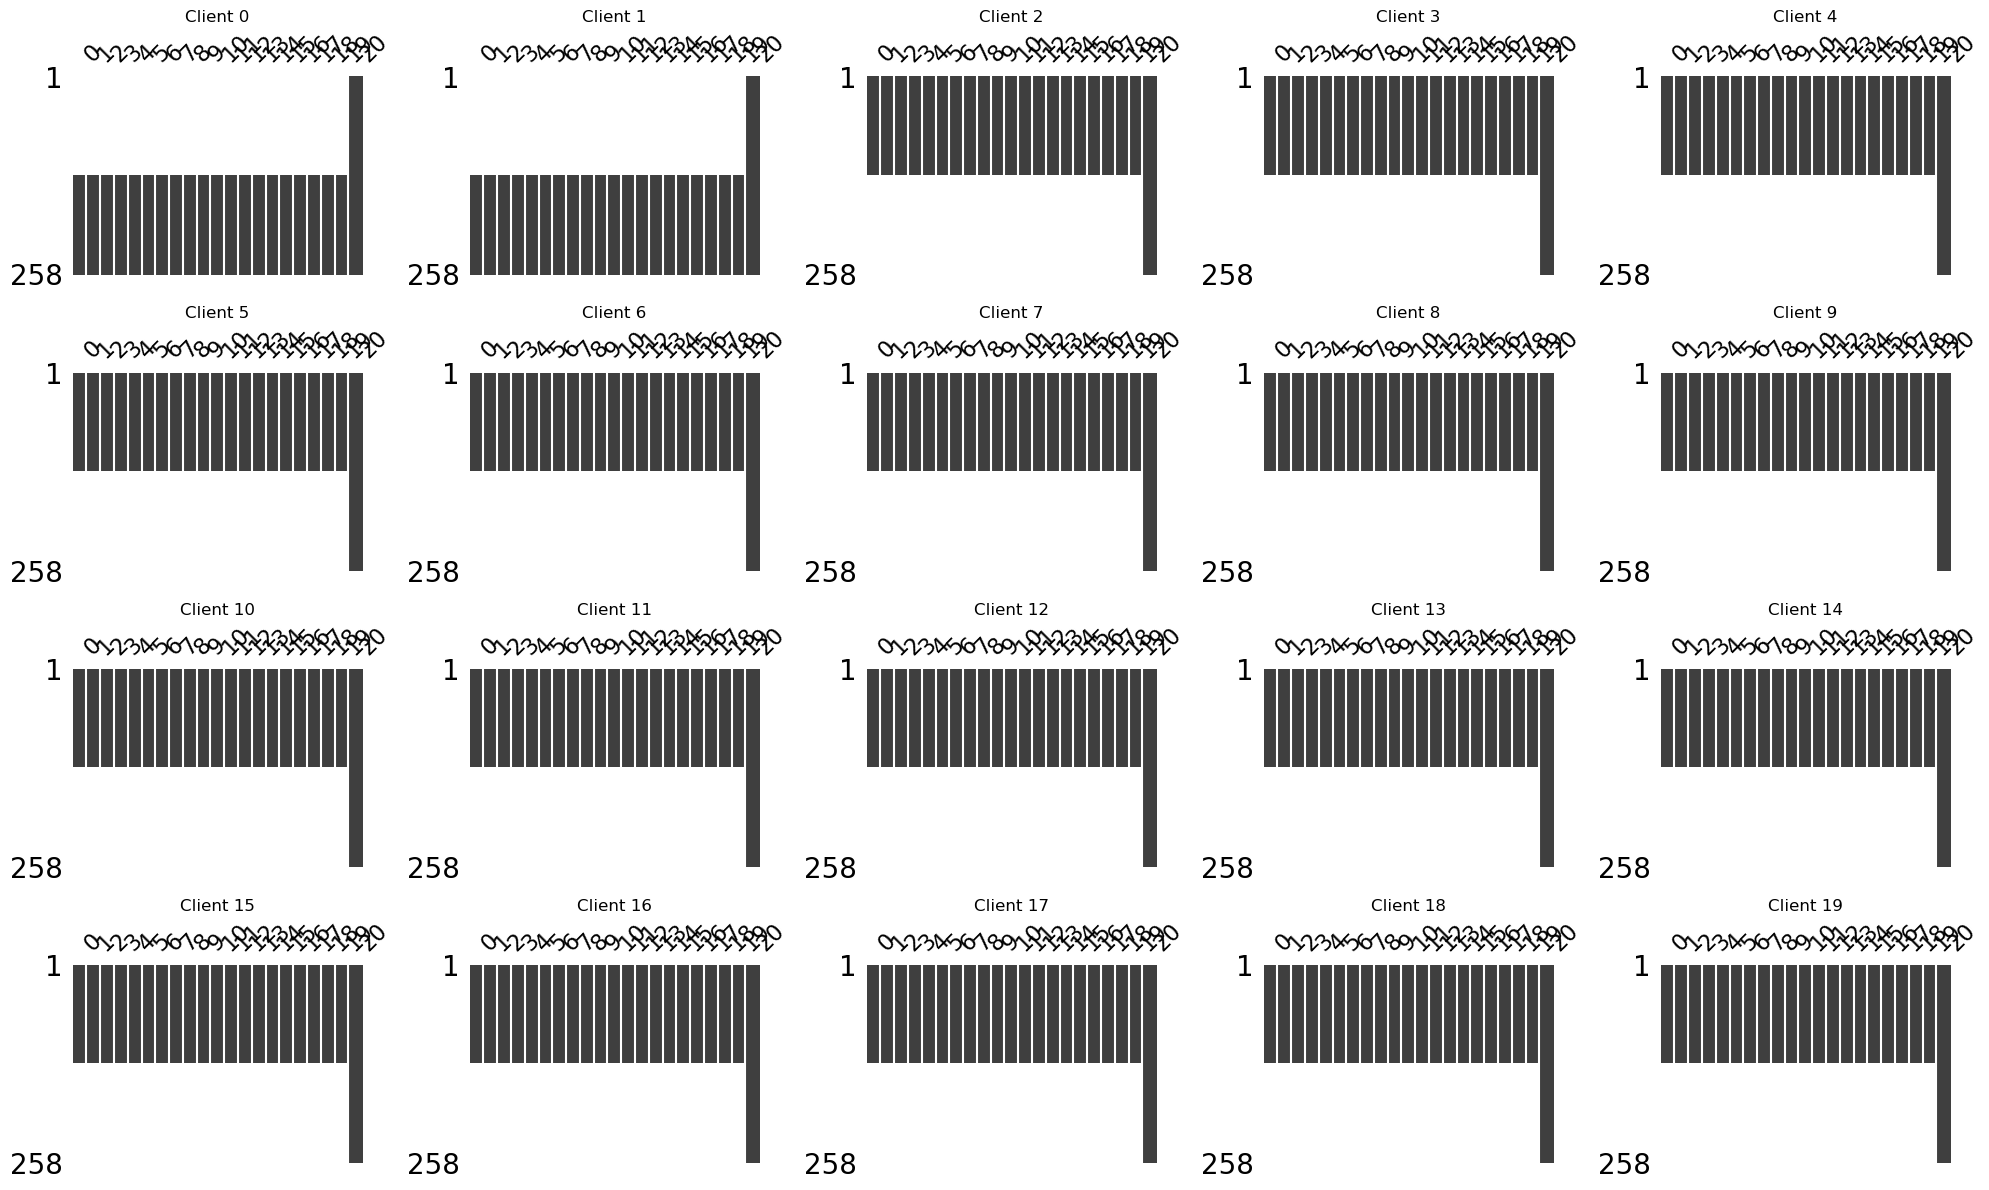

In [90]:
config = experiment_config_template.copy()
config['data']['dataset_name'] = 'ijcnn_balanced_pca'
config['num_clients'] = 20
config['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config['missing_simulate']['mf_strategy'] = 'all'
config['missing_simulate']['mm_strategy'] = 'mary_lr@sp=extreme'
config['data_partition']['strategy'] = 'sample@p=0.01'

configuration = config
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)
visualize_ms(data_ms_clients)

### Simple Averaging

In [91]:
configuration['agg_strategy_imp']['strategy'] = 'fedavg-s'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret13 = server.run()

2023-07-19 10:24:11.431 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 103.31634199997643


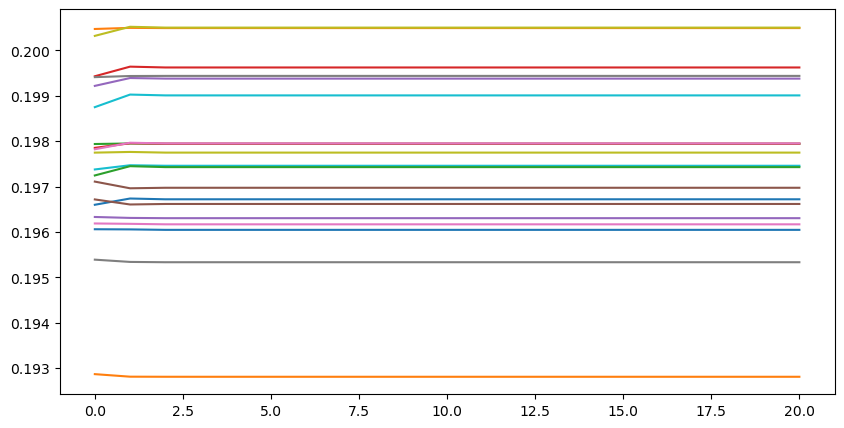

In [93]:
x = list(range(len(ret13['client_imp_history'])))
client_ids = list(ret13['client_imp_history'][0][2]['metrics'].keys())

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for client_id in client_ids:
    y = [ret13['client_imp_history'][i][2]['metrics'][client_id]['imp@rmse'] for i in x]
    ax.plot(x, y, label=client_id)
plt.show()

### Complentary Models

In [92]:
configuration['agg_strategy_imp']['strategy'] = 'testavg2'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret14 = server.run()

testavg2


2023-07-19 10:25:52.682 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 101.22823510004673


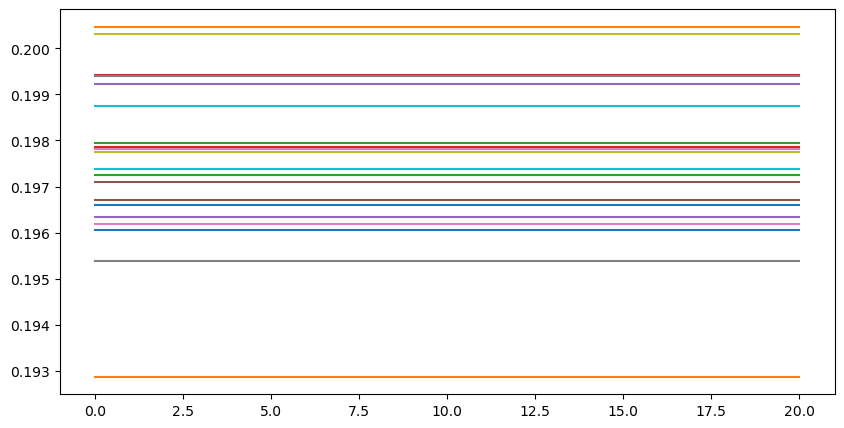

In [94]:
x = list(range(len(ret14['client_imp_history'])))
client_ids = list(ret14['client_imp_history'][0][2]['metrics'].keys())

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for client_id in client_ids:
    y = [ret14['client_imp_history'][i][2]['metrics'][client_id]['imp@rmse'] for i in x]
    ax.plot(x, y, label=client_id)
plt.show()

## MARY RL

sample {'p': '0.01'}
['mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_left'
 'mary_sigmoid_left' 'mary_sigmoid_left' 'mary_sigmoid_left'
 'mary_sigmoid_left' 'mary_sigmoid_left' 'mary_sigmoid_left'
 'mary_sigmoid_left' 'mary_sigmoid_left' 'mary_sigmoid_left'
 'mary_sigmoid_left' 'mary_sigmoid_left' 'mary_sigmoid_left'
 'mary_sigmoid_left' 'mary_sigmoid_left' 'mary_sigmoid_left'
 'mary_sigmoid_left' 'mary_sigmoid_left']


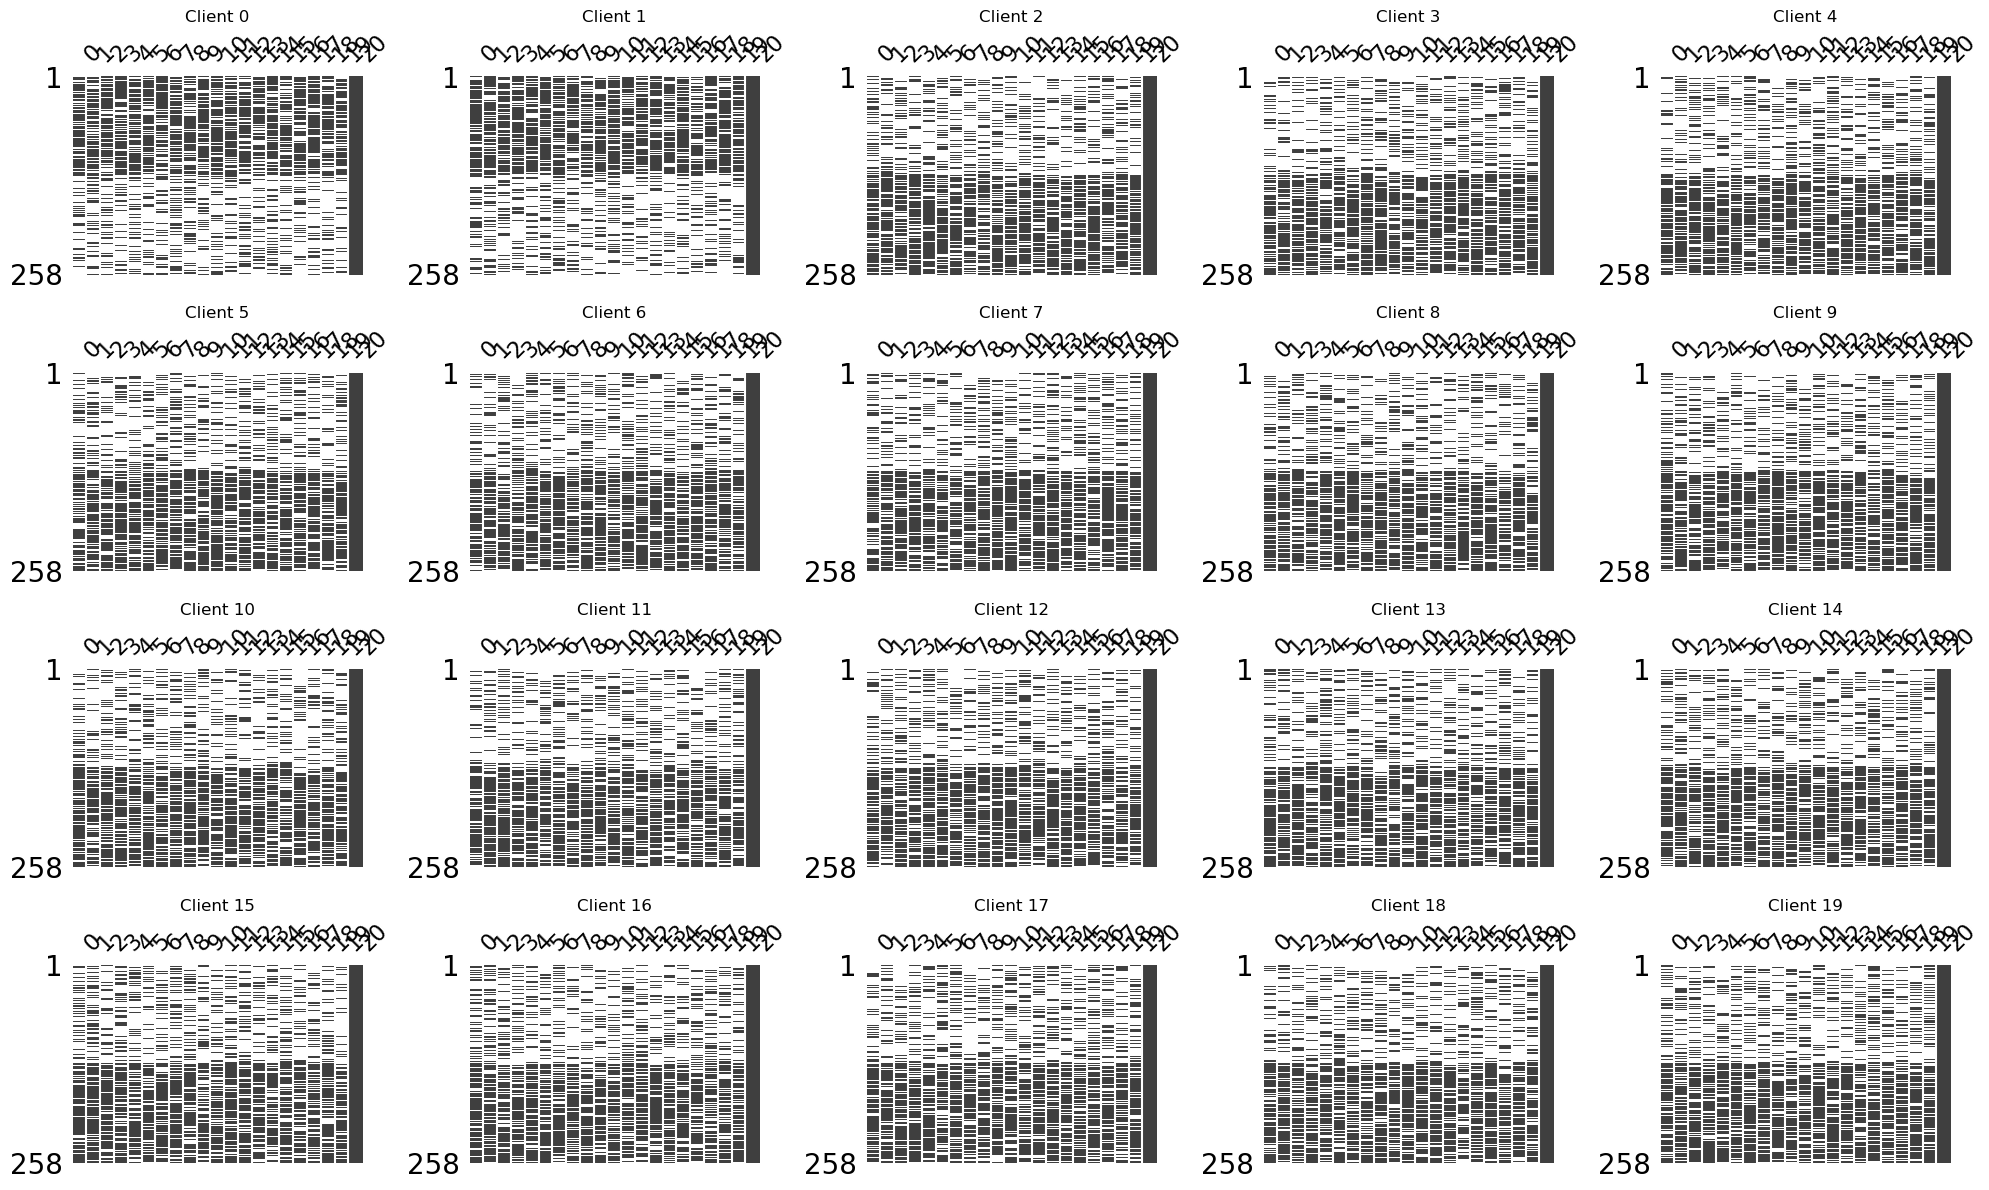

In [95]:
config = experiment_config_template.copy()
config['data']['dataset_name'] = 'ijcnn_balanced_pca'
config['num_clients'] = 20
config['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config['missing_simulate']['mf_strategy'] = 'all'
config['missing_simulate']['mm_strategy'] = 'mary_sigmoid_rl@sp=extreme'
config['data_partition']['strategy'] = 'sample@p=0.01'

configuration = config
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)
visualize_ms(data_ms_clients)

### Simple Averaging

In [96]:
configuration['agg_strategy_imp']['strategy'] = 'fedavg-s'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret15 = server.run()

2023-07-19 10:28:10.508 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 103.16049959999509


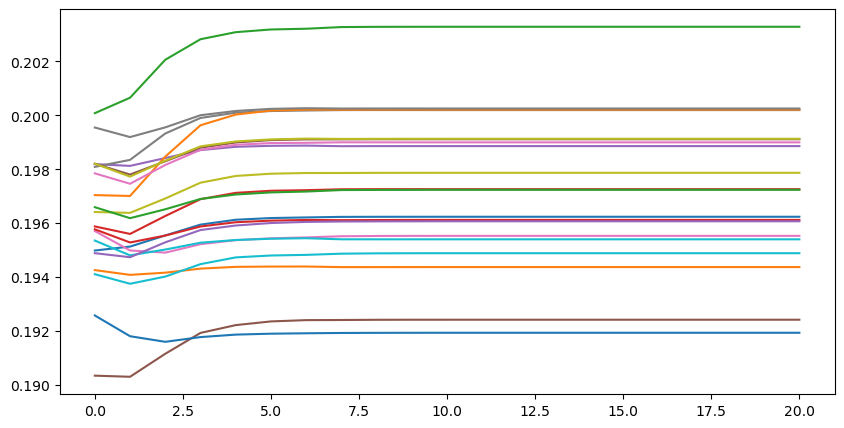

In [98]:
x = list(range(len(ret15['client_imp_history'])))
client_ids = list(ret15['client_imp_history'][0][2]['metrics'].keys())

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for client_id in client_ids:
    y = [ret15['client_imp_history'][i][2]['metrics'][client_id]['imp@rmse'] for i in x]
    ax.plot(x, y, label=client_id)
plt.show()

### Complementary Models

In [97]:
configuration['agg_strategy_imp']['strategy'] = 'testavg2'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret16 = server.run()

testavg2


2023-07-19 10:29:52.782 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 102.2371227000258


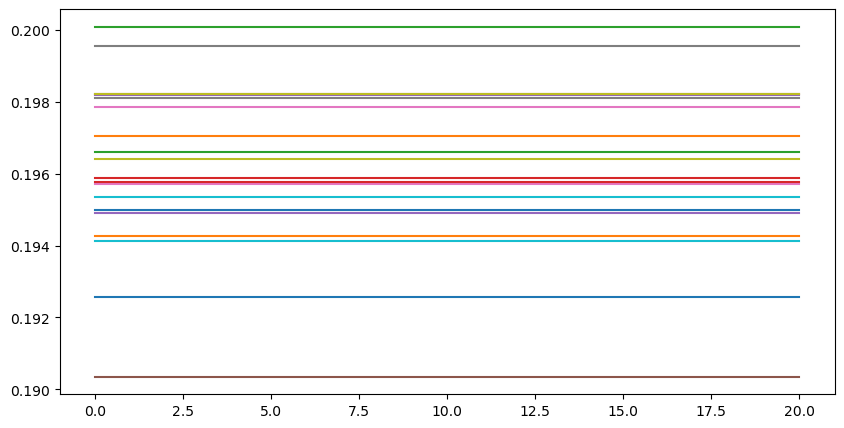

In [99]:
x = list(range(len(ret16['client_imp_history'])))
client_ids = list(ret16['client_imp_history'][0][2]['metrics'].keys())

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for client_id in client_ids:
    y = [ret16['client_imp_history'][i][2]['metrics'][client_id]['imp@rmse'] for i in x]
    ax.plot(x, y, label=client_id)
plt.show()